## 数据清理与特征工程

### 1. 处理movie_item

载入包文件

In [15]:
import pandas as pd
import numpy as np
import json
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
# %load_ext scalene

载入数据

In [16]:
# 载入电影数据
data_item = pd.read_json('../douban_movie/data/movie_item.json', lines=True)
print('电影数目：' ,data_item.shape[0])

data_item['movie_id'] = data_item['movie_id'].apply(lambda x: int(x[0][3:]))  # [电影-1300267] -> int(1300267)
data_item['comment_num'] = data_item['comment_num'].apply(lambda x: int(x[2:-1]))  # 全部 62309 条 -> int(62309)
data_item['question_num'] = data_item['question_num'].apply(lambda x: int(x[2:-1]))  # 全部23个 -> int(23)
data_item['rating_num'] = data_item['rating_num'].apply(lambda x: float(x[0]))   # [9.2] -> float(9.2)
data_item['rating_per_stars1'] = data_item['rating_per_stars1'].apply(lambda x: float(x[:-1]))   # 0.1% -> float(0.1)
data_item['rating_per_stars2'] = data_item['rating_per_stars2'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars3'] = data_item['rating_per_stars3'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars4'] = data_item['rating_per_stars4'].apply(lambda x: float(x[:-1]))  
data_item['rating_per_stars5'] = data_item['rating_per_stars5'].apply(lambda x: float(x[:-1]))
data_item['release_date'] = data_item['release_date'].apply(lambda x: int(x[0][1:-1]))  # [(1939)] -> int(1939)
data_item['vote_num'] = data_item['vote_num'].apply(lambda x: int(x[0]))   # [272357] -> int(272357)
data_item['movie_title'] = data_item['movie_title'].apply(lambda x: (x[0]))
# [238分钟] -> 238
data_item.loc[15,'runtime'] = ['80分钟']
pattern = '\d+'
import re
data_item['runtime'] = data_item['runtime'].apply(lambda x: (x[0]))
data_item['runtime'] = data_item['runtime'].str.findall(pattern,flags=re.IGNORECASE).apply(lambda x: int(x[0]))

def Intro(introduces):
    Intro_ = ''
    for intro in introduces:
        intro = intro.strip()
        Intro_ += intro
    return Intro_
data_item['intro'] = data_item.intro.apply(Intro)

电影数目： 246


In [17]:
#data_item[data_item.movie_id == 6146955]

In [18]:
data_item.head(1)

,country,intro,vote_num,movie_title,starring,comment_num,rating_per_stars4,language,directedBy,movie_id,runtime,rating_per_stars3,release_date,rating_per_stars2,rating_per_stars5,rating_num,genre,rating_per_stars1,question_num
0,美国,美国南北战争前夕，南方农场塔拉庄园的千金斯嘉丽（费雯·丽 Vivien Leigh 饰）爱上...,272357,乱世佳人 Gone with the Wind,"[托马斯·米切尔, 芭芭拉·欧内尔, 费雯·丽, 伊夫林·凯耶斯, 安·卢瑟福德, 乔治·里...",62309,27.0,英语,"[维克多·弗莱明, 乔治·库克, 山姆·伍德]",1300267,238,5.5,1939,0.3,67.1,9.2,"[剧情, 爱情, 历史, 战争]",0.1,23


In [19]:
data_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            246 non-null    object 
 1   intro              246 non-null    object 
 2   vote_num           246 non-null    int64  
 3   movie_title        246 non-null    object 
 4   starring           246 non-null    object 
 5   comment_num        246 non-null    int64  
 6   rating_per_stars4  246 non-null    float64
 7   language           246 non-null    object 
 8   directedBy         246 non-null    object 
 9   movie_id           246 non-null    int64  
 10  runtime            246 non-null    int64  
 11  rating_per_stars3  246 non-null    float64
 12  release_date       246 non-null    int64  
 13  rating_per_stars2  246 non-null    float64
 14  rating_per_stars5  246 non-null    float64
 15  rating_num         246 non-null    float64
 16  genre              246 non

In [20]:
# 总评分最高的前10部电影
data_item.sort_values('rating_num', ascending=False)[['movie_title','rating_num']].head(10)

,movie_title,rating_num
243,肖申克的救赎 The Shawshank Redemption,9.6
236,控方证人 Witness for the Prosecution,9.6
102,美丽人生 La vita è bella,9.5
98,霸王别姬,9.5
107,十二怒汉 12 Angry Men,9.4
103,阿甘正传 Forrest Gump,9.4
101,这个杀手不太冷 Léon,9.4
100,辛德勒的名单 Schindler's List,9.4
108,机器人总动员 WALL·E,9.3
120,海豚湾 The Cove,9.3


《肖申克的救赎》果然仍旧排在第一位，不过排在第二的《控方证人》确不在豆瓣Top250中排名靠前，看来豆瓣官方的排名是另有依据的。

接下来，将分别分析最受欢迎的电影类别genre、电影出品国家country、导演directedBy、演员starring、电影语言language、电影时长runtime和电影评价数vote_num。

首先，我们来定义三个函数以及电影类别和国别：


In [21]:
def column_expand(data, column, list_values):
    for cl in list_values:
        tt = data_item[column].apply(lambda x: str(x)).str.contains('\W'+cl+'\W')
        uu = data_item[column].apply(lambda x: str(x)).str.contains('^'+cl+'$')
        ee = data_item[column].apply(lambda x: str(x)).str.contains(cl+'\s')
        ff = data_item[column].apply(lambda x: str(x)).str.contains('\s'+cl)
        cl_ = tt | uu| ee | ff
        cl_ *= 1
        data['%s_%s' %(column ,cl)] = cl_
        
class_movie = ['剧情','爱情','喜剧','科幻','动作','悬疑','犯罪','恐怖','青春'
               ,'励志','战争','文艺','黑色幽默','传记','情色','暴力','音乐','家庭']
country_movie = ['大陆','美国','香港','台湾','日本','韩国','英国','法国','德国','意大利','西班牙','印度','泰国','俄罗斯'
 ,'伊朗','加拿大','澳大利亚','爱尔兰','瑞典','巴西','丹麦']

def get_values_list(data, column, sep=None):
    Language_values=[]
    def countLANG(Languages):
        for language in Languages:
            language = language.strip()
            if language in Language_values: 
                continue
            else:
                Language_values.append(language)
    if sep:
        pd.DataFrame(data[column].str.split(sep))[column].apply(countLANG);
    else:
        data[column].apply(countLANG);
    return Language_values

def Paiming(data, column, list_values):
    column_expand(data, column, list_values)
    df = pd.DataFrame( 
        {'数目':[data['%s_%s' %(column, p)].sum() for p in list_values]}
        , index=list_values).sort_values('数目', ascending=False)
    return df
# 列表匹配
#column_expand(data_item, 'genre', class_movie)
#column_expand(data_item,  'country', country_movie)
#column_expand(data_item,  'language', get_values_list(data_item, 'language', sep='/'))
#column_expand(data_item,  'starring', get_values_list(data_item, 'starring'))

In [22]:
# 最受欢迎的电影类别排名
Paiming(data_item, 'genre', class_movie)

,数目
剧情,191
爱情,62
喜剧,49
犯罪,45
动作,32
悬疑,29
家庭,27
科幻,25
战争,17
传记,12


In [23]:
# 最受欢迎的电影导演排名
temp = Paiming(data_item, 'directedBy', get_values_list(data_item, 'directedBy'))
print('共有%s位导演入选TOP250电影榜:' %len(temp))
temp.head(10)

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

共有196位导演入选TOP250电影榜:


/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

,数目
克里斯托弗·诺兰,7
宫崎骏,7
史蒂文·斯皮尔伯格,6
王家卫,5
李安,4
大卫·芬奇,3
刘镇伟,3
理查德·林克莱特,3
朱塞佩·托纳多雷,3
詹姆斯·卡梅隆,3


In [24]:
# 最受欢迎的演员排名
temp = Paiming(data_item, 'starring', get_values_list(data_item, 'starring'))
print('共有%s位演员入选TOP250电影榜:' %len(temp))
temp.head(11)

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  tt = data_item[column].apply(lambda x: str(x)).str.contains('\W'+cl+'\W')
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  uu = data_item[column].apply(lambda x: str(x)).str.contains('^'+cl+'$')
/var/folders/j9/x9wd0pm15

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

共有2317位演员入选TOP250电影榜:


,数目
张国荣,8
汤姆·汉克斯,7
布拉德·皮特,7
张曼玉,7
梁朝伟,7
伊桑·霍克,6
琼·艾伦,6
马特·达蒙,6
雨果·维文,6
莱昂纳多·迪卡普里奥,6


In [25]:
# 最受欢迎的出品国家排名
temp = Paiming(data_item, 'country', country_movie)
print('共有%s个出品国家入选TOP250电影榜:' %len(temp))
temp.head(15)
temp

共有21个出品国家入选TOP250电影榜:


/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

,数目
美国,141
英国,34
日本,29
法国,27
香港,26
德国,19
意大利,10
韩国,8
大陆,7
加拿大,7


In [26]:
def geod_world(df, title, legend = False):
    """
    temp0 = temp.reset_index()
    df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
                   ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
    """
    import geopandas as gp
    from matplotlib import pyplot as plt
    %matplotlib inline
    import matplotlib
    import seaborn as sns
    matplotlib.rc('figure', figsize = (14, 7))
    matplotlib.rc('font', size = 14)
    matplotlib.rc('axes', grid = False)
    matplotlib.rc('axes', facecolor = 'white')

    world_geod = gp.GeoDataFrame.from_file('./world_countries_shp/World_countries_shp.shp')
    data_geod = gp.GeoDataFrame(df)   # 转换格式
    da_merge = world_geod.merge(data_geod, on = 'NAME', how = 'left') # 合并
    sum(np.isnan(da_merge['NUM'])) # 
    da_merge['NUM'][np.isnan(da_merge['NUM'])] = 14.0#填充缺失数据
    da_merge.plot('NUM', k = 20, cmap = plt.cm.Blues,alpha= 1,legend = legend)
    plt.title(title, fontsize=15)#设置图形标题
    plt.gca().xaxis.set_major_locator(plt.NullLocator())#去掉x轴刻度
    plt.gca().yaxis.set_major_locator(plt.NullLocator())#去年y轴刻度

In [28]:
# country_dict = {'大陆':'China','美国':'United States','香港':'Hong Kong','台湾':'Taiwan, Province of China'
#                  ,'日本':'Japan','韩国':'Korea, Republic of','英国':'United Kingdom','法国':'France','德国':'Germany'
#                  ,'意大利':'Italy','西班牙':'Spain','印度':'India','泰国':'Thailand','俄罗斯':'Russian Federation'
#                  ,'伊朗':'Iran','加拿大':'Canada','澳大利亚':'Australia','爱尔兰':'Ireland','瑞典':'Sweden'
#                  ,'巴西':'Brazil','丹麦':'Denmark'}

# temp0 = temp.reset_index()
# df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
#                    ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
# geod_world(df, 'The popularity of movie in the world ')

In [29]:
# 最受欢迎的语言排名
temp = Paiming(data_item, 'language', get_values_list(data_item, 'language', sep='/'))
print('共有%s种语言入选TOP250电影榜:' %len(temp))
temp.head(15)

/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

共有60种语言入选TOP250电影榜:


/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s' %(column ,cl)] = cl_
/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_92967/4181110315.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

,数目
英语,170
法语,41
日语,37
汉语普通话,33
德语,25
粤语,24
意大利语,19
西班牙语,15
俄语,12
拉丁语,8


In [30]:
# 电影时长的排名
data_item.sort_values('runtime', ascending=False)[['movie_title','runtime']].head(10)

,movie_title,runtime
0,乱世佳人 Gone with the Wind,238
221,牯岭街少年杀人事件 牯嶺街少年殺人事件,237
235,美国往事 Once Upon a Time in America,229
199,教父2 The Godfather: Part Ⅱ,202
110,指环王3：王者无敌 The Lord of the Rings: The Return of...,201
100,辛德勒的名单 Schindler's List,195
104,泰坦尼克号 Titanic,194
230,绿里奇迹 The Green Mile,189
11,与狼共舞 Dances with Wolves,181
210,指环王2：双塔奇兵 The Lord of the Rings: The Two Towers,179


In [31]:
# 电影投票数的排名
data_item.sort_values('vote_num', ascending=False)[['movie_title','vote_num']].head(10)

,movie_title,vote_num
243,肖申克的救赎 The Shawshank Redemption,877684
101,这个杀手不太冷 Léon,838853
105,盗梦空间 Inception,766735
103,阿甘正传 Forrest Gump,714946
28,三傻大闹宝莱坞 3 Idiots,676928
106,千与千寻 千と千尋の神隠し,666166
104,泰坦尼克号 Titanic,657294
98,霸王别姬,631204
171,让子弹飞,612443
26,海上钢琴师 La leggenda del pianista sull'oceano,601595


In [32]:
# 电影评价数的排名
data_item.sort_values('comment_num', ascending=False)[['movie_title','comment_num']].head(10)

,movie_title,comment_num
243,肖申克的救赎 The Shawshank Redemption,206334
105,盗梦空间 Inception,201260
113,少年派的奇幻漂流 Life of Pi,197790
28,三傻大闹宝莱坞 3 Idiots,192686
101,这个杀手不太冷 Léon,192324
83,疯狂动物城 Zootopia,182765
109,怦然心动 Flipped,178532
111,星际穿越 Interstellar,176341
98,霸王别姬,167573
171,让子弹飞,155386


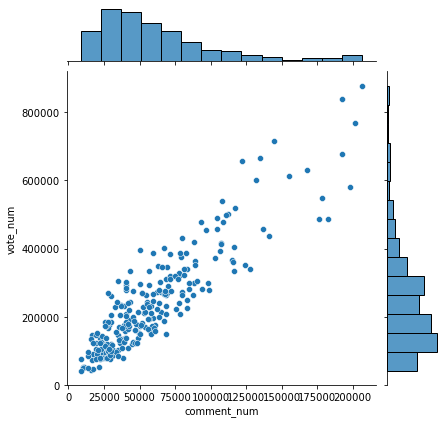

In [33]:
import seaborn as sns
sns.jointplot(x="comment_num", y="vote_num", data=data_item)

In [34]:
# 电影问题数的排名
data_item.sort_values('question_num', ascending=False)[['movie_title','question_num']].head(10)

,movie_title,question_num
111,星际穿越 Interstellar,1215
196,消失的爱人 Gone Girl,282
83,疯狂动物城 Zootopia,264
19,彗星来的那一夜 Coherence,200
161,心迷宫,184
163,超能陆战队 Big Hero 6,142
172,布达佩斯大饭店 The Grand Budapest Hotel,135
224,爆裂鼓手 Whiplash,133
223,恐怖游轮 Triangle,119
231,再次出发之纽约遇见你 Begin Again,116


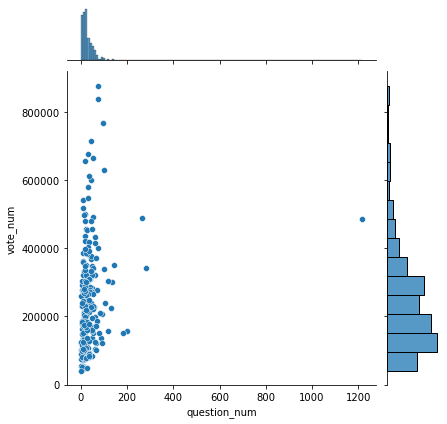

In [35]:
sns.jointplot(x="question_num", y="vote_num", data=data_item)

In [36]:
# 根据电影发布时间的规律
def plot2y(x_data, x_label, type1, y1_data, y1_color, y1_label, type2, y2_data, y2_color, y2_label, title):
    _, ax1 = plt.subplots()
    
    if type1 == 'hist':
        ax1.hist(x_data, histtype='stepfilled', bins=200, color = y1_color)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('symlog')
        ax1.set_title(title)

    elif type1 == 'plot':
        ax1.plot(x_data, y1_data, color = y1_color)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('linear')
        ax1.set_title(title)
        
    elif type1 == 'scatter':
        ax1.scatter(x_data, y1_data, color = y1_color, s = 10, alpha = 0.75)
        ax1.set_ylabel(y1_label, color = y1_color) 
        ax1.set_xlabel(x_label)
        ax1.set_yscale('symlog')
        ax1.set_title(title)
        
    if type2 == 'bar':
        ax2 = ax1.twinx()
        ax2.bar(x_data, y2_data, color = y2_color, alpha = 0.75)
        ax2.set_ylabel(y2_label, color = y2_color)
        ax2.set_yscale('linear')
        ax2.spines['right'].set_visible(True)
        
    elif type2 == 'scatter':
        ax2 = ax1.twinx()
        ax2.scatter(x_data, y2_data, color = y2_color, s = 10, alpha = 0.75)
        ax2.set_ylabel(y2_label, color = y2_color)
        ax2.set_yscale('linear')
        ax2.spines['right'].set_visible(True)

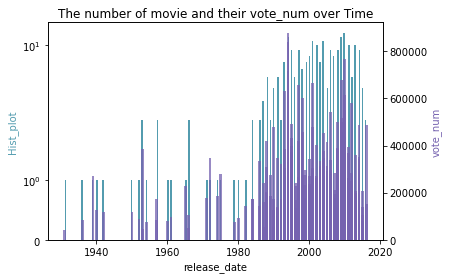

In [37]:
from matplotlib import pyplot as plt
plot2y(x_data = data_item.release_date
           , x_label = 'release_date'
           , type1 = 'hist'
           , y1_data = data_item.vote_num #(无效果)
           , y1_color = '#539caf'
           , y1_label = 'Hist_plot'
           , type2 = 'bar'
           , y2_data = data_item.vote_num
           , y2_color = '#7663b0'
           , y2_label = 'vote_num'
           , title = 'The number of movie and their vote_num over Time')

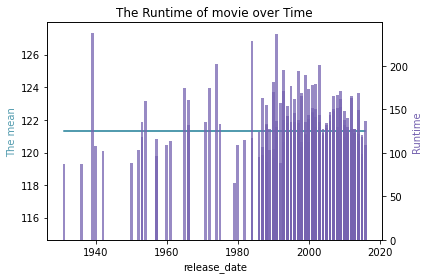

In [38]:
plot2y(x_data = data_item.release_date
           , x_label = 'release_date'
           , type1 = 'plot'
           , y1_data = data_item.runtime.apply(lambda x : data_item.runtime.mean())
           , y1_color = '#539caf'
           , y1_label = 'The mean'
           , type2 = 'bar'
           , y2_data = data_item.runtime
           , y2_color = '#7663b0'
           , y2_label = 'Runtime'
           , title = 'The Runtime of movie over Time')

In [39]:
# 1～5星级投票的百分比

/Users/chengwei/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/chengwei/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/chengwei/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/chengwei/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:1699:

Text(0.5, 1.0, 'Rating percent for stars 1-5')

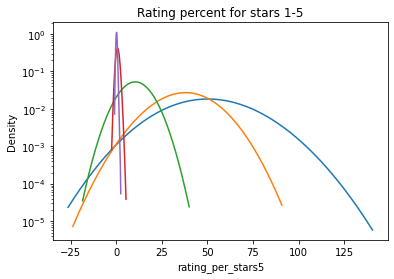

In [40]:
sns.kdeplot(data_item.rating_per_stars5, bw=2)
sns.kdeplot(data_item.rating_per_stars4, bw=2)
sns.kdeplot(data_item.rating_per_stars3, bw=2)
sns.kdeplot(data_item.rating_per_stars2, bw=2)
sns.kdeplot(data_item.rating_per_stars1, bw=2)
plt.yscale('log')
plt.title('Rating percent for stars 1-5')

In [41]:
# 电影简介的情感分析

In [42]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy as np
import codecs
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(10.0,5.0)
from wordcloud import WordCloud # 词云包

In [43]:
# 导入、分词、去停用词
def lcut(Intro_movie):
    segment=[]
    segs = jieba.lcut(Intro_movie) # jiaba.lcut()   
    for seg in segs:
        if len(seg)>1 and seg!='\r\n':
            segment.append(seg)
    return segment

def dropstopword(segment):
    # 去停用词
    words_df = pd.DataFrame({'segment':segment})
    stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
    #stopwords.head()
    return words_df[~words_df.segment.isin(stopwords.stopword)].segment.values.tolist()

In [44]:
# 基于TextRank算法的关键词抽取(仅动词和动名词)
import jieba.analyse as analyse

data_item['keywords'] = data_item.intro.apply(lcut)\
                .apply(dropstopword)\
                .apply(lambda x : " ".join(x))\
                .apply(lambda x:" ".join(analyse.textrank(x, topK=8, withWeight=False, allowPOS=('n','ns','vn', 'v'))))
data_item.sort_values('rating_num', ascending=False)[['movie_title','keywords']].head(10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/jieba.cache
Loading model cost 0.371 seconds.
Prefix dict has been built successfully.


,movie_title,keywords
243,肖申克的救赎 The Shawshank Redemption,监狱 希望 本片 惩罚 牢狱 管理层 接近 杀害
236,控方证人 Witness for the Prosecution,律师 嫌疑犯 遗嘱 警方 护士 刑案 爵士 本片
102,美丽人生 La vita è bella,儿子 圭多 法西斯 早安 公主 政权 游戏 妻子
98,霸王别姬,人生 程蝶衣 关系 风云 升级 变迁 本质 情仇
107,十二怒汉 12 Angry Men,陪审员 有罪 陪审团 被告 父亲 过程 证人 涉嫌
103,阿甘正传 Forrest Gump,妈妈 外交 美国 性格 坚强 至爱 离别 思念
101,这个杀手不太冷 Léon,女孩 邻居家 杀害 警方 缉毒 混杂着 暂避 救回
100,辛德勒的名单 Schindler's List,统治 工厂 德国 屠杀 军官 贿赂 拯救 出众
108,机器人总动员 WALL·E,地球 机器人 漫长 垃圾 公司 生活 喜欢 飞船
120,海豚湾 The Cove,海豚 拯救 太地 渔民 渔村 县太地 景色 理查德


### 2. 处理movie_comment

In [45]:
import pandas as pd
import numpy as np
import json
# 短评数据
movie_comment_file = ['../douban_movie/data/movie_comment%s.json' %j for j in [ i for i in range(20,220,20)] +[225,250]]
com = []
for f in movie_comment_file:
    lines = open(f, 'rb').readlines()
    com.extend([json.loads(elem.decode("utf-8")) for elem in lines])
data_com = pd.DataFrame(com)
print(data_com)
data_com['movie_id'] = data_com['movie_id'].apply(lambda x: int(x[0][5:]))
data_com['content'] = data_com.content.apply(lambda x: x[0].strip())
data_com['people'] = data_com.people.apply(lambda x: x.strip())
data_com['people'] = data_com.people_url.apply(lambda x: x[30:-1])
data_com['useful_num'] = data_com.useful_num.apply(lambda x: int(x))
def regular_nonstar(x):
    if x == 'comment-time':
        return 'allstar00 rating'
    else:
        return x
data_com['star'] = data_com.star.apply(regular_nonstar).apply(lambda x: int(x[7]))
data_com['time'] = pd.to_datetime(data_com.time.apply(lambda x: x[0]))
print('获取的总短评数：' ,data_com.shape[0])

              movie_id                                                URL  \
0       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
1       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
2       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
3       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
4       [cbtn-1292052]  https://movie.douban.com/subject/1292052/comments   
...                ...                                                ...   
249555  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249556  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249557  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249558  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   
249559  [cbtn-3541415]  https://movie.douban.com/subject/3541415/comme...   

                    star                                            content

In [46]:
data_com = data_com[~data_com.comment_id.duplicated()]
print('去重后的总短评数：' ,data_com.shape[0])

people_url = data_com.people_url.unique().tolist()
np.savetxt('../douban_movie/bin/people_url.out', people_url, fmt='%s')
urllist = np.loadtxt('../douban_movie/bin/people_url.out', dtype='|S').tolist()
len(urllist)

去重后的总短评数： 249512


38599

In [47]:
data_com = data_com.drop(['URL','people_url'], axis=1)
print(data_com.head(1))
data_com['label'] = (data_com.star >=3) *1

   movie_id  star     content  comment_id    people  useful_num  \
0   1292052     5  不需要女主角的好电影     2050003  kingfish       11314   

                 time  
0 2006-03-22 12:38:09  


In [48]:
data_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249512 entries, 0 to 249559
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   movie_id    249512 non-null  int64         
 1   star        249512 non-null  int64         
 2   content     249512 non-null  object        
 3   comment_id  249512 non-null  int64         
 4   people      249512 non-null  object        
 5   useful_num  249512 non-null  int64         
 6   time        249512 non-null  datetime64[ns]
 7   label       249512 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 17.1+ MB


In [49]:
data_com.head(2)

,movie_id,star,content,comment_id,people,useful_num,time,label
0,1292052,5,不需要女主角的好电影,2050003,kingfish,11314,2006-03-22 12:38:09,1
1,1292052,5,恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》,32514679,ruxiaoguo,7277,2008-02-27 21:43:23,1


Text(0.5, 0, 'Number of short_comment of each movie')

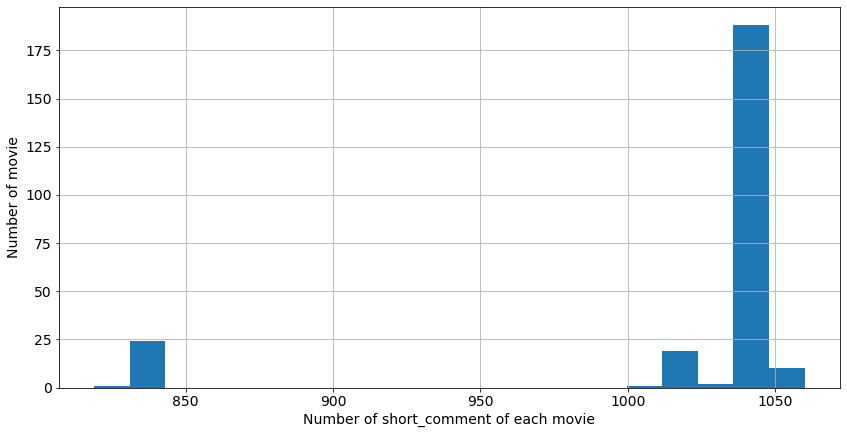

In [50]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

data_com.movie_id.value_counts().hist(bins=20)
plt.ylabel('Number of movie')
plt.xlabel('Number of short_comment of each movie')

In [51]:
# 1. 就《肖申克的救赎》这个电影而言

In [52]:
data_com_X = data_com[data_com.movie_id == 1292052]
print(data_com_X.head(1))
print('爬取《肖申克的救赎》的短评数：', data_com_X.shape[0])

   movie_id  star     content  comment_id    people  useful_num  \
0   1292052     5  不需要女主角的好电影     2050003  kingfish       11314   

                 time  label  
0 2006-03-22 12:38:09      1  
爬取《肖申克的救赎》的短评数： 1040


In [53]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

Text(0, 0.5, 'Number of short_comment')

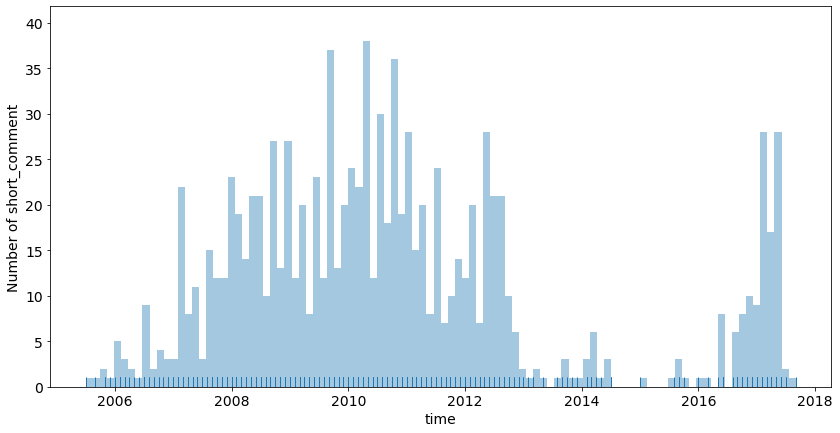

In [54]:
sns.distplot(data_com_X.time.apply(lambda x: int(x.year)+float(x.month/12.0)), bins=100, kde=False, rug=True)
plt.xlabel('time')
plt.ylabel('Number of short_comment')

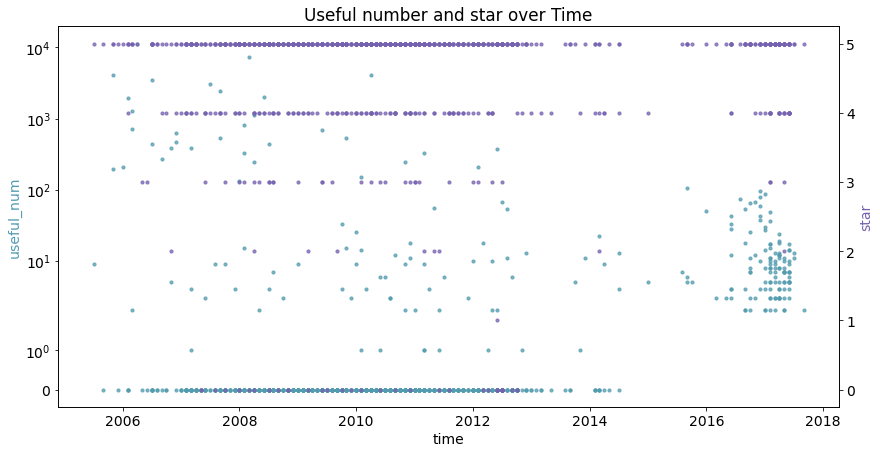

In [55]:
plot2y(x_data = data_com_X.time.apply(lambda x: int(x.year)+float(x.month/12.0))
           , x_label = 'time'
           , type1 = 'scatter'
           , y1_data = data_com_X['useful_num']
           , y1_color = '#539caf'
           , y1_label = 'useful_num'
           , type2 = 'scatter'
           , y2_data = data_com_X['star']
           , y2_color = '#7663b0'
           , y2_label = 'star'
           , title = 'Useful number and star over Time')

In [56]:
# 短评词云

In [57]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
from wordcloud import WordCloud # 词云包

In [58]:
content_X = data_com_X.content.dropna().values.tolist()
print(content_X)
# 导入、分词
segment=[]
for line in content_X: 
    try:
        segs = jieba.lcut(line) # jiaba.lcut()   
        for seg in segs:
            if len(seg)>1 and seg!='\r\n':
                segment.append(seg)
    except:
        print(line)
        continue

['不需要女主角的好电影', '恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》', '策划了19年的私奔……', '当年的奥斯卡颁奖礼上，被如日中天的《阿甘正传》掩盖了它的光彩，而随着时间的推移，这部电影在越来越多的人们心中的地位已超越了《阿甘》。每当现实令我疲惫得产生无力感，翻出这张碟，就重获力量。毫无疑问，本片位列男人必看的电影前三名！回顾那一段经典台词：“有的人的羽翼是如此光辉，即使世界上最黑暗的牢狱，也无法长久地将他围困！”', '关于希望最强有力的注释。', '有种鸟是关不住的.', '忒经典的东西,我要带去我的坟墓', '超级喜欢超级喜欢,不看的话人生不圆满.', '“这是一部男人必看的电影。”人人都这么说。但单纯从性别区分，就会让这电影变狭隘。《肖申克的救赎》突破了男人电影的局限，通篇几乎充满令人难以置信的温馨基调，而电影里最伟大的主题是“希望”。\r\n当我们无奈地遇到了如同肖申克一般囚禁了心灵自由的那种囹圄，我们是无奈的老布鲁克，灰心的瑞德，还是智慧的安迪？运用智慧，信任希望，并且勇敢面对恐惧心理，去打败它？\r\n经典的电影之所以经典，因为他们都在做同一件事——让你从不同的角度来欣赏希望的美好。', '真的不喜欢，不好看，没感觉', '这无疑是我看得最多的一部经典,爱死', '点在哪？浅白的励志片诶', '人的生命不过是从一个洞穴通往另一个世界..然后在那个世界的雨中继续颤抖.i hope', 'Fear Can Hold You Prisoner, Hope Can Set You Free', '没有人会不喜欢吧！书和电影都好。', 'Hope is a good thing, and maybe the best thing of all.', '越狱我感觉就是改编自这个', '看完让人很振奋', '有那么好吗？？？？？', '在我的心目中,它一直都是最被高估的电影。', 'hope is a good thing', '大众经典我从不感冒，为什么？我欣赏水平不行？', '我最喜欢的电影', '一部没有爱情与美女的电影,却光芒四射', '这样的男人谁会舍得背叛。。。', '酣畅淋漓', '不多说了', '因为1994年台湾引进了一部比较卖座的老片The Sting，被错译成了《刺激》。到了1995年本片上映时，片商觉得其剧情与《刺

In [59]:
# 去停用词
words_df = pd.DataFrame({'segment':segment})
stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
#stopwords.head()
words_df=words_df[~words_df.segment.isin(stopwords.stopword)]

In [60]:
# 统计词频
# words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数":np.size})
# words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False
words_stat = words_df.groupby('segment').agg(计数=pd.NamedAgg(column='segment', aggfunc='size')).reset_index().sort_values(by='计数', ascending=False)

#words_stat.head()

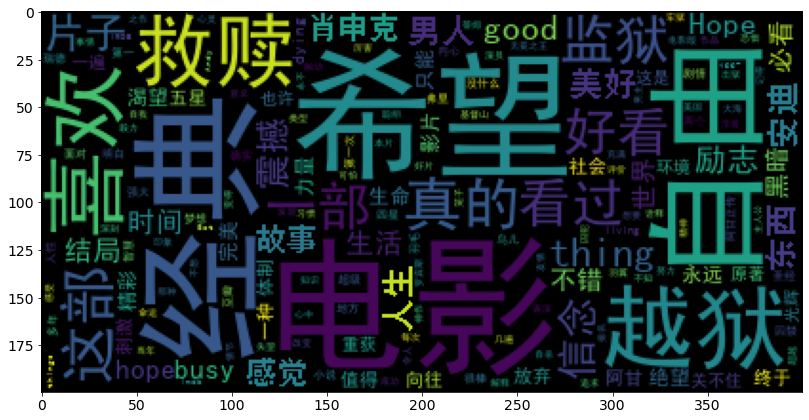

In [61]:
# 词云
wordcloud = WordCloud(font_path="../simhei.ttf"
                      ,background_color="black"
                      ,max_font_size=80)
word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

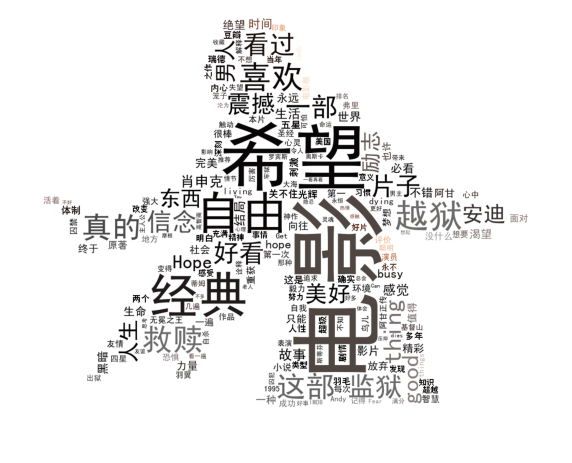

In [62]:
# 加入自定义图
# from scipy.misc import 
import imageio
matplotlib.rcParams['figure.figsize']=(10.0,10.0)
from wordcloud import WordCloud,ImageColorGenerator
bimg=imageio.imread('cover.jpg')
wordcloud=WordCloud(background_color="white",mask=bimg,font_path='../simhei.ttf',max_font_size=200)
word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence)
bimgColors=ImageColorGenerator(bimg)
plt.axis("off")
plt.imshow(wordcloud.recolor(color_func=bimgColors))

In [63]:
# 用朴素贝叶斯完成中文文本分类器

In [64]:
data_com_X.label.value_counts()
print(data_com_X)

       movie_id  star                                            content  \
0       1292052     5                                         不需要女主角的好电影   
1       1292052     5                       恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》   
2       1292052     5                                        策划了19年的私奔……   
3       1292052     5  当年的奥斯卡颁奖礼上，被如日中天的《阿甘正传》掩盖了它的光彩，而随着时间的推移，这部电影在越...   
4       1292052     5                                       关于希望最强有力的注释。   
...         ...   ...                                                ...   
20655   1292052     5                                               不多说了   
20656   1292052     5                       何谓救赎，何谓自由。斯蒂芬金写的故事总是透着人性的光辉。   
20657   1292052     5  希望真好啊~结局把我感动坏了~特别的积极向上~绝望的时候就拿来看看吧~另外男猪不仅IQ EQ...   
20658   1292052     5                                            据说还蛮好看的   
20659   1292052     5                                          不能错过，看完惊讶   

       comment_id           people  useful_num                time  label  
0         2

In [65]:
# 词云
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd

def preprocess_text(content_lines,sentences,category):
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

In [66]:
data_com_X_1 = data_com_X[data_com_X.label == 1]
print(data_com_X[data_com_X.label == 1])
data_com_X_0 = data_com_X[data_com_X.label == 0]
# print(data_com_X[data_com_X.label == 0])

       movie_id  star                                            content  \
0       1292052     5                                         不需要女主角的好电影   
1       1292052     5                       恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》   
2       1292052     5                                        策划了19年的私奔……   
3       1292052     5  当年的奥斯卡颁奖礼上，被如日中天的《阿甘正传》掩盖了它的光彩，而随着时间的推移，这部电影在越...   
4       1292052     5                                       关于希望最强有力的注释。   
...         ...   ...                                                ...   
20655   1292052     5                                               不多说了   
20656   1292052     5                       何谓救赎，何谓自由。斯蒂芬金写的故事总是透着人性的光辉。   
20657   1292052     5  希望真好啊~结局把我感动坏了~特别的积极向上~绝望的时候就拿来看看吧~另外男猪不仅IQ EQ...   
20658   1292052     5                                            据说还蛮好看的   
20659   1292052     5                                          不能错过，看完惊讶   

       comment_id           people  useful_num                time  label  
0         2

In [67]:
# 下采样
sentences=[]
# print(data_com_X_1.content.dropna().values.tolist())
preprocess_text(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
while n <20:
    preprocess_text(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1

In [68]:
import random
random.shuffle(sentences)
print(sentences)
for sentence in sentences[:2]:
    print(sentence[0], sentence[1])

[('牢底', 'like'), ('那么', 'nlike'), ('艾迪 一只 羽毛 太漂亮 那么 多年 妻子 赎罪 其实 根本 不是 一个 向往 自由', 'like'), ('浓缩 精华版 越狱 讨论 东西 越狱 值得 深思', 'like'), ('虚假 巧合 当作 精妙 对比 突兀 后果 往往 使人 惊叹 不是 启发 脱离 过去 过于 决绝', 'nlike'), ('自作聪明', 'nlike'), ('never thought out Shawshank can run out of the jail At the end of the movie the escape make me scared about the patience the plan the power realization of the dream Nice for Shawshank and it nice for everyone', 'nlike'), ('希望 东西', 'nlike'), ('时候 平淡无奇 结局 出乎意料 看后 回味无穷', 'like'), ('信念', 'nlike'), ('喜欢 救赎 这个 知道 为什么', 'nlike'), ('监狱 电影 登峰造极', 'like'), ('希望 最好 事情 希望', 'nlike'), ('喜欢 救赎 这个 知道 为什么', 'nlike'), ('明明 勇敢 心式 狗血', 'nlike'), ('哪怕 看到 这样 完美 结局 依然 隐隐 不安 算不算 缺乏 安全感', 'like'), ('生命 无限 敬畏', 'like'), ('越狱 他哥 评论 捧得 太高 不予置评', 'like'), ('平凡 人生 平凡 自己', 'like'), ('面前 还是 卑微 保持沉默', 'like'), ('希望 最好 事情 希望', 'nlike'), ('如果 希望 带来 绝望', 'like'), ('没有 什么 公不 公平 只有 自己 命运 自己 手里', 'like'), ('小时 22 一刻 未曾 浪费 这个 世界 的话 人忙 美好 从未 消逝 希望', 'like'), ('类型 想要 感人 挺难 一点 不觉 震撼', 'nlike'), ('伟大', 'like'), ('什么 大智大勇

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score
#from sklearn.model_selection import train_test_split
# print(sentences)
x,y=zip(*sentences) #解压
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
    analyzer='word', # tokenise by character ngrams 
    ngram_range=(1,4), # use ngrams of size 1 and 2 
    max_features=20000, # keep the most common 1000 ngrams
)
vec.fit(x)
def stratifiedkfold_cv(x,y,clf_class,shuffle=True,n_splits=5,**kwargs):
    stratifiedk_fold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle)
    y_pred = y[:]
    for train_index, test_index in stratifiedk_fold.split(x,y):
        X_train, X_test = x[train_index], x[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

NB = MultinomialNB
print(precision_score(y, stratifiedkfold_cv(vec.transform(x),np.array(y),NB), average='macro'))

0.8825511754615858


In [72]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

class TextClassifier():
    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier
        self.vectorizer = CountVectorizer(analyzer='word'
                                          ,ngram_range=(1,4)
                                          ,max_features=20000)
    def features(self, X):
        return self.vectorizer.transform(X)
    
    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)
        
    def predict(self, x):
        return self.classifier.predict(self.features([x]))
    
    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

In [73]:
text_classifier=TextClassifier()
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1234)
text_classifier.fit(x_train,y_train)
print(text_classifier.predict('难得看到这么惨烈的公安警匪大战。'))
print(text_classifier.predict('好看'))
print(text_classifier.predict('好想甩出一麻袋星'))
print(text_classifier.score(x_test,y_test))

['like']
['nlike']
['like']
0.9214876033057852


In [74]:
# 用SVC完成中文文本分类器

In [75]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC

class TextClassifier():
    def __init__(self, classifier=SVC(kernel='linear')):
        self.classifier = classifier
        self.vectorizer = TfidfVectorizer(analyzer='word'
                                          ,ngram_range=(1,4)
                                          ,max_features=20000)

    def features(self, X):
        return self.vectorizer.transform(X)
    
    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)
    
    def predict(self, x):
        return self.classifier.predict(self.features([x]))
    
    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

In [76]:
text_classifier=TextClassifier()
text_classifier.fit(x_train,y_train)
print(text_classifier.predict('一点 不觉得震撼'))
print(text_classifier.predict('好看'))
print(text_classifier.score(x_test,y_test))

['like']
['like']
0.987603305785124


In [77]:
# 用Facebook FastText有监督完成中文文本分类

In [78]:
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append("__label__"+str(category)+" , "+" ".join(segs))
        except:
            print(line)
            continue
            
# 生成训练数据            
sentences=[]
print(data_com_X_1.content.dropna().values.tolist())
preprocess_text(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
print(data_com_X_0.content.dropna().values.tolist())
while n <20:
    preprocess_text(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1
random.shuffle(sentences)

print("writing data to fasttext supervised learning format...")
out = open('train_data_supervised_fasttext.txt','w' )#,encoding='utf-8') 
for sentence in sentences:
    out.write(sentence+"\n") 
print("done!")

['不需要女主角的好电影', '恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》', '策划了19年的私奔……', '当年的奥斯卡颁奖礼上，被如日中天的《阿甘正传》掩盖了它的光彩，而随着时间的推移，这部电影在越来越多的人们心中的地位已超越了《阿甘》。每当现实令我疲惫得产生无力感，翻出这张碟，就重获力量。毫无疑问，本片位列男人必看的电影前三名！回顾那一段经典台词：“有的人的羽翼是如此光辉，即使世界上最黑暗的牢狱，也无法长久地将他围困！”', '关于希望最强有力的注释。', '有种鸟是关不住的.', '忒经典的东西,我要带去我的坟墓', '超级喜欢超级喜欢,不看的话人生不圆满.', '“这是一部男人必看的电影。”人人都这么说。但单纯从性别区分，就会让这电影变狭隘。《肖申克的救赎》突破了男人电影的局限，通篇几乎充满令人难以置信的温馨基调，而电影里最伟大的主题是“希望”。\r\n当我们无奈地遇到了如同肖申克一般囚禁了心灵自由的那种囹圄，我们是无奈的老布鲁克，灰心的瑞德，还是智慧的安迪？运用智慧，信任希望，并且勇敢面对恐惧心理，去打败它？\r\n经典的电影之所以经典，因为他们都在做同一件事——让你从不同的角度来欣赏希望的美好。', '这无疑是我看得最多的一部经典,爱死', '点在哪？浅白的励志片诶', '人的生命不过是从一个洞穴通往另一个世界..然后在那个世界的雨中继续颤抖.i hope', 'Fear Can Hold You Prisoner, Hope Can Set You Free', '没有人会不喜欢吧！书和电影都好。', 'Hope is a good thing, and maybe the best thing of all.', '越狱我感觉就是改编自这个', '看完让人很振奋', '在我的心目中,它一直都是最被高估的电影。', 'hope is a good thing', '我最喜欢的电影', '一部没有爱情与美女的电影,却光芒四射', '这样的男人谁会舍得背叛。。。', '酣畅淋漓', '不多说了', '因为1994年台湾引进了一部比较卖座的老片The Sting，被错译成了《刺激》。到了1995年本片上映时，片商觉得其剧情与《刺激》有类似的地方（大概都属于高智商的复仇？），因此被译成了《刺激1995》，1998年又有一部片子Return T

['真的不喜欢，不好看，没感觉', '有那么好吗？？？？？', '大众经典我从不感冒，为什么？我欣赏水平不行？', '虚假的巧合被当作精妙对比，突兀的后果往往使人惊叹而不是受启发，脱离过去过于决绝。', '其实没那么好', '有点好奇这部片为何被过度赞誉到这个地步···', '原來那個鏡頭是來自這部電影的。總算把imdb最高分的電影看了。但是我的評分就不方便給了。', '真的不喜欢，不好看，没感觉', '看我的名字。说明了一切。', '在硕大的阶梯教室看这样精彩的电影，心里的那份震撼和激动，历历在目。', '最爱', '明明是勇敢的心式的狗血剧。', '我很喜欢救赎这个词,不知道为什么.', '虽然没有传闻中的那么好看，不过给5星也是绝对够的。', '在茫然失措的时候，或许它可以给你一个内心暖暖的冲动。', '经典无法复制。', '这么多好评。其实也不差我这一个。', 'Your  friend ,Andy!!!!!', '自由高于生命', '好片 不解释', "never thought out Shawshank can run out of the jail. At the end of the movie, the escape make me scared about the patience, the plan, the power realization of the dream. Nice for Shawshank, and it's nice for everyone", '很经典，看了之后觉得自己的境界又提升了。', '超喜欢摩根弗里曼', '确实是经典~', '完美诠释大众审美都是屎的经典影片。', '一般般', '男人的触动', 'hope is good thing', '上影视鉴赏的好处就是把以前没看完的电影看完。', '是很不错，不过不觉得该是IMDB中排名第一的电影......至于《刺激1999》的港译，只能说......', '自作聪明', '类型片想要感人，挺难。一点不觉震撼', '如果它是国产片，可能会被归为红歌。', '生活就是那最后的五百码', '信念', '很要命的电影音乐，\r\n很要命的故事编剧', '希望是最好的事情', '希望是最好的事情，恩，有希望就好，', '的确是有地方，让人落下泪来。', '希望是个好东西

In [79]:
# # 调用fastTest模型
# import fasttext
# # 有监督
# classifier=fasttext.train_supervised('train_data_supervised_fasttext.txt', label='__label__')
# # 对模型进行评估
# result = classifier.test('train_data_supervised_fasttext.txt')
# print('P@1:',result.precision)
# print('R@1:',result.recall)
# print('Number of examples:',result.nexamples)

In [80]:
# # 测试一下实际效果
# texts = '真心 不好看'
# labels=classifier.predict(texts)
# print(labels[0][0])
# labels=classifier.predict_proba(texts,k=2)
# print(labels[0])

In [81]:
# 用Facebook FastText无监督学习

In [82]:
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text_unsupervised(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append(" ".join(segs))
        except:
            print(line)
            continue

In [83]:
sentences=[]
preprocess_text_unsupervised(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
while n <20:
    preprocess_text_unsupervised(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1
random.shuffle(sentences)

print("writing data to fasttext unsupervised learning format...")
out=open('train_data_unsupervised_fasttext.txt','w') 
for sentence in sentences:
    out.write(sentence+"\n") 
print("done!")

writing data to fasttext unsupervised learning format...
done!


In [85]:
import fasttext
# Skipgram model
# model=fasttext.skipgram('train_data_unsupervised_fasttext.txt','model') 
model = fasttext.train_unsupervised('train_data_unsupervised_fasttext.txt', model='skipgram')
print(model.words) # list of words in dictionary
# CBOW model
#model=fasttext.cbow('train_data_unsupervised_fasttext.txt','model') 
#print(model.words) # list of words in dictionary

Read 0M words
Number of words:  300
Number of labels: 0


['</s>', '电影', '希望', '经典', '自由', '喜欢', '好看', '真的', '震撼', '地方', '事情', '救赎', '这部', '感觉', '越狱', '完美', '看过', 'thing', '信念', 'good', '男人', '大众', '东西', '電影', '要命', 'Shawshank', '故事', '生活', 'hope', '监狱', '不错', '生命', '永远', '精彩', '一部', '只能', '体制', '片子', '刺激', '第一', '确实', '第一次', '内心', '弗里', '自我', '心灵', '好片', '类型', 'imdb', 'Andy', '演员', '想要', '诠释', '解释', '厉害', 'IMDB', '基督山', '触动', '排名', '感人', '一点', '勇敢', '音乐', '摩根', '假释', '伯爵', '美好', '高于', '主题', '妻子', 'movie', '经典影片', '编剧', '安迪', '信仰', '人生', '不行', '欣赏', '感冒', 'Your', '励志', '穿越', '水平', '好处', '影视', 'dream', '国产片', '几个', '名字', '呼唤', '激动', '历历在目', '精妙', 'power', '最高分', '冲动', '脱离', '启发', '境界', '五百', '后果', '提升', '变奏', '使人', '總算', '上班族', '落下', '泪来', '肖申克', '茫然失措', '地步', '暖暖的', '赞誉', '評分', '給了', '不觉', '过度', '遍看', '好奇', '那份', '复制', '配乐', 'bbm', '挺难', '红歌', '阶梯教室', '传闻中', '硕大', 'Trailer', '鉴赏', '這部', '没看', '害得', 'Hope', '自作聪明', '鏡頭', 'escape', '虚假', '巧合', '惊叹', '决绝', '当作', '那個', '大智大勇', '心愿', '原來', 'nice', '约会', '一棵', '橡树', '盒子', '挖出来', '时个', '港译', '1999',

Progress: 100.0% words/sec/thread:   72954 lr:  0.000000 avg.loss:  4.119108 ETA:   0h 0m 0s


In [ ]:
# asdasdasd

In [ ]:
# 用CNN做中文文本分类

In [87]:
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue
            
sentences=[]
preprocess_text(data_com_X_1.content.dropna().values.tolist() ,sentences ,'like')
n=0
while n <20:
    preprocess_text(data_com_X_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1
random.shuffle(sentences)     

from sklearn.model_selection import train_test_split
x,y=zip(*sentences)
train_data,test_data,train_target,test_target=train_test_split(x, y, random_state=1234)

In [88]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
# %load_ext scalene
"""
基于卷积神经网络的中文文本分类
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

learn = tf.contrib.learn
FLAGS = None
# 文档最长长度
MAX_DOCUMENT_LENGTH = 100
# 最小词频数
MIN_WORD_FREQUENCE = 2
# 词嵌入的维度
EMBEDDING_SIZE = 20
# filter个数
N_FILTERS = 10 # 10个神经元
# 感知野大小
WINDOW_SIZE = 20
#filter的形状
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS] 
# 池化
POOLING_WINDOW = 4
POOLING_STRIDE = 2
n_words = 0

def cnn_model(features, target):
    """
    2层的卷积神经网络，用于短文本分类
    """
    # 先把词转成词嵌入
    # 我们得到一个形状为[n_words, EMBEDDING_SIZE]的词表映射矩阵
    # 接着我们可以把一批文本映射成[batch_size, sequence_length,EMBEDDING_SIZE]的矩阵形式
    target = tf.one_hot(target, 15, 1, 0) #对词编码
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    word_vectors = tf.expand_dims(word_vectors, 3)
    with tf.variable_scope('CNN_Layer1'):
        # 添加卷积层做滤波
        conv1 = tf.contrib.layers.convolution2d(word_vectors
                                                ,N_FILTERS
                                                ,FILTER_SHAPE1
                                                ,padding='VALID')
        # 添加RELU非线性
        conv1 = tf.nn.relu(conv1) 
        # 最大池化
        pool1 = tf.nn.max_pool(conv1
                               ,ksize=[1, POOLING_WINDOW, 1, 1]
                               ,strides=[1, POOLING_STRIDE, 1, 1]
                               ,padding='SAME')
        # 对矩阵进行转置，以满足形状
        pool1 = tf.transpose(pool1, [0, 1, 3, 2])
    with tf.variable_scope('CNN_Layer2'):
        # 第2卷积层
        conv2 = tf.contrib.layers.convolution2d(pool1
                                                ,N_FILTERS
                                                ,FILTER_SHAPE2
                                                ,padding='VALID') 
        # 抽取特征
        pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])
        
    # 全连接层
    logits = tf.contrib.layers.fully_connected(pool2, 15, activation_fn=None)
    loss = tf.losses.softmax_cross_entropy(target, logits) 
    # 优化器
    train_op = tf.contrib.layers.optimize_loss(loss
                                               ,tf.contrib.framework.get_global_step()
                                               ,optimizer='Adam'
                                               ,learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)

AttributeError: module 'tensorflow' has no attribute 'contrib'

In [ ]:
global n_words
# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE) 
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data)))
n_words=len(vocab_processor.vocabulary_) 
print('Total words:%d'%n_words)

cate_dic={'like':1,'nlike':0}
y_train = pd.Series(train_target).apply(lambda x:cate_dic[x] , train_target)
y_test = pd.Series(test_target).apply(lambda x:cate_dic[x] , test_target)

In [ ]:
# 构建模型
classifier=learn.SKCompat(learn.Estimator(model_fn=cnn_model))

# 训练和预测
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class'] 
score=metrics.accuracy_score(y_test,y_predicted) 
print('Accuracy:{0:f}'.format(score))

In [ ]:
# 用RNN做中文文本分类

In [91]:
"""
使用RNN完成文本分类
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.layers.python.layers import encoders

learn = tf.contrib.learn

FALGS = None

ModuleNotFoundError: No module named 'tensorflow.contrib'

In [90]:
MAX_DOCUMENT_LENGTH=15
MIN_WORD_FREQUENCE=1
EMBEDDING_SIZE=50
global n_words

# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE)
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data))) 
n_words = len(vocab_processor.vocabulary_)
print('Total words: %d' % n_words)

def bag_of_words_model(features, target): 
    """
    先转成词袋模型
    """
    target = tf.one_hot(target, 15, 1, 0)
    features = encoders.bow_encoder(features
                                    ,vocab_size=n_words
                                    ,embed_dim=EMBEDDING_SIZE)
    logits = tf.contrib.layers.fully_connected(features, 15
                                               ,activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    train_op = tf.contrib.layers.optimize_loss(loss
                                               ,tf.contrib.framework.get_global_step()
                                               ,optimizer='Adam'
                                               ,learning_rate=0.01)
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)

model_fn = bag_of_words_model
classifier = learn.SKCompat(learn.Estimator(model_fn=model_fn))

# Train and predict
classifier.fit(x_train, y_train, steps=1000)
y_predicted = classifier.predict(x_test)['class']
score = metrics.accuracy_score(y_test, y_predicted)
print('Accuracy: {0:f}'.format(score))

NameError: name 'learn' is not defined

In [ ]:
# 用GRU来完成中文文本分类

In [ ]:
def rnn_model(features,target): 
    """
    用RNN模型（这里用的是GRU）完成文本分类
    """
    # Convert indexes of words into embeddings.
    # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
    # maps word indexes of the sequence into [batch_size,sequence_length,
    # EMBEDDING_SIZE].
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    # Split into list of embedding per word, while removing doc length dim。
    # word_list results to be a list of tensors [batch_size,EMBEDDING_SIZE].
    word_list = tf.unstack(word_vectors, axis=1)
    
    # Create a Gated Recurrent Unit cell with hidden size of EMBEDDING_SIZE.
    cell = tf.contrib.rnn.GRUCell(EMBEDDING_SIZE)
    
    # Create an unrolled Recurrent Neural Networks to length of
    # MAX_DOCUMENT_LENGTH and passes word_list as inputs for each unit.
    _, encoding = tf.contrib.rnn.static_rnn(cell, word_list, dtype=tf.float32)
    
    # Given encoding of RNN, take encoding of last step (e.g hidden size of the
    # neural network of last step) and pass it as features for logistic
    # regression over output classes.
    target = tf.one_hot(target, 15, 1, 0)
    logits = tf.contrib.layers.fully_connected(encoding, 15, activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    
    # Create a training op.
    train_op = tf.contrib.layers.optimize_loss(
            loss,
            tf.contrib.framework.get_global_step(),
            optimizer='Adam',
            learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)


model_fn = rnn_model 
classifier=learn.SKCompat(learn.Estimator(model_fn=model_fn))

#Train and predict
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class']
score=metrics.accuracy_score(y_test,y_predicted)
print('Accuracy:{0:f}'.format(score))

In [ ]:
def pred(commment):
    sentences=[]
    preprocess_text([commment] ,sentences, 'unknown')
    x,y=zip(*sentences)
    x_tt = np.array(list(vocab_processor.transform([x[0]])))
    
    if classifier.predict(x_tt)['class'][0]:
        print('like')
    else:
        print('nlike')
pred('好精彩的电影！')
pred('烂片啊！')

In [ ]:
# 2. 全部影片的短评数据分析

In [ ]:
# data_com_0

In [ ]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')
sns.distplot(data_com.time.apply(lambda x: int(x.year)+float(x.month/12.0)), bins=100, kde=False, rug=True)
plt.xlabel('time')
plt.ylabel('Number of short_comment')

In [ ]:
plot2y(x_data = data_com.time.apply(lambda x: int(x.year)+float(x.month/12.0))
           , x_label = 'time'
           , type1 = 'scatter'
           , y1_data = data_com_X['useful_num']
           , y1_color = '#539caf'
           , y1_label = 'useful_num'
           , type2 = 'scatter'
           , y2_data = data_com_X['star']
           , y2_color = '#7663b0'
           , y2_label = 'star'
           , title = 'Useful number and star over Time')

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import jieba   # 分词包
import numpy
import codecs
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(10.0,5.0)
from wordcloud import WordCloud # 词云包

content_X = data_com_X.content.dropna().values.tolist()
# 导入、分词
segment=[]
for line in content_X: 
    try:
        segs = jieba.lcut(line) # jiaba.lcut()   
        for seg in segs:
            if len(seg)>1 and seg!='\r\n':
                segment.append(seg)
    except:
        print(line)
        continue
        
# 去停用词
words_df = pd.DataFrame({'segment':segment})
stopwords = pd.read_csv("../stopwords.txt" 
                      ,index_col=False
                      ,quoting=3
                      ,sep="\t"
                      ,names=['stopword']
                      ,encoding='utf-8') # quoting=3 全不引用    
#stopwords.head()
words_df=words_df[~words_df.segment.isin(stopwords.stopword)]

# 统计词频
# words_stat = words_df.groupby(by=['segment'])['segment'].agg({"计数":np.size})
# words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False
words_stat = words_df.groupby('segment').agg(计数=pd.NamedAgg(column='segment', aggfunc='size')).reset_index().sort_values(by='计数', ascending=False)

#words_stat.head()

# 词云
wordcloud = WordCloud(font_path="../simhei.ttf"
                      ,background_color="white"
                      ,max_font_size=80)
word_frequence={x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

In [ ]:
# Deeplearning

In [ ]:
data_com.label.value_counts()

In [ ]:
data_com_1 = data_com[data_com.label == 1]
data_com_0 = data_com[data_com.label == 0]

In [ ]:
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

In [ ]:
sentences=[]
preprocess_text(data_com_1.content.dropna().values.tolist() ,sentences ,'like')
preprocess_text(data_com_0.content.dropna().values.tolist() ,sentences ,'nlike')

In [ ]:
n=0
while n <20:
    preprocess_text(data_com_0.content.dropna().values.tolist() ,sentences ,'nlike')
    n +=1
    print('Now n=',n)
random.shuffle(sentences)

In [ ]:
from sklearn.model_selection import train_test_split
x,y=zip(*sentences)
train_data,test_data,train_target,test_target=train_test_split(x, y, random_state=1234)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.layers.python.layers import encoders

learn = tf.contrib.learn

FALGS = None
MAX_DOCUMENT_LENGTH=15
MIN_WORD_FREQUENCE=1
EMBEDDING_SIZE=50
global n_words

global n_words
# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE) 
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data)))
n_words=len(vocab_processor.vocabulary_) 
print('Total words:%d'%n_words)

cate_dic={'like':1,'nlike':0}
y_train = pd.Series(train_target).apply(lambda x:cate_dic[x] , train_target)
y_test = pd.Series(test_target).apply(lambda x:cate_dic[x] , test_target)

In [ ]:
def rnn_model(features,target): 
    """
    用RNN模型（这里用的是GRU）完成文本分类
    """
    # Convert indexes of words into embeddings.
    # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
    # maps word indexes of the sequence into [batch_size,sequence_length,
    # EMBEDDING_SIZE].
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    # Split into list of embedding per word, while removing doc length dim。
    # word_list results to be a list of tensors [batch_size,EMBEDDING_SIZE].
    word_list = tf.unstack(word_vectors, axis=1)
    
    # Create a Gated Recurrent Unit cell with hidden size of EMBEDDING_SIZE.
    cell = tf.contrib.rnn.GRUCell(EMBEDDING_SIZE)
    
    # Create an unrolled Recurrent Neural Networks to length of
    # MAX_DOCUMENT_LENGTH and passes word_list as inputs for each unit.
    _, encoding = tf.contrib.rnn.static_rnn(cell, word_list, dtype=tf.float32)
    
    # Given encoding of RNN, take encoding of last step (e.g hidden size of the
    # neural network of last step) and pass it as features for logistic
    # regression over output classes.
    target = tf.one_hot(target, 15, 1, 0)
    logits = tf.contrib.layers.fully_connected(encoding, 15, activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    
    # Create a training op.
    train_op = tf.contrib.layers.optimize_loss(
            loss,
            tf.contrib.framework.get_global_step(),
            optimizer='Adam',
            learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)


model_fn = rnn_model 
classifier=learn.SKCompat(learn.Estimator(model_fn=model_fn))

#Train and predict
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class']
score=metrics.accuracy_score(y_test,y_predicted)
print('Accuracy:{0:f}'.format(score))

In [ ]:
def pred(commment):
    sentences=[]
    preprocess_text([commment] ,sentences, 'unknown')
    x,y=zip(*sentences)
    x_tt = np.array(list(vocab_processor.transform([x[0]])))
    
    if classifier.predict(x_tt)['class'][0]:
        print('like')
    else:
        print('nlike')
pred('好精彩的电影！')

In [ ]:
pred('烂片啊！')

In [ ]:
len(Xpeople_url)

In [ ]:
Xpeople_url = data_com[data_com.movie_id == 1292052].people_url.values.tolist()
np.savetxt('../douban_movie/bin/X_people_url.out', Xpeople_url, fmt='%s')

In [ ]:
#people_url = data_com.people_url.unique().tolist()
#np.savetxt('./douban_movie/bin/people_url.out', people_url, fmt='%s')
!ls ./douban_movie/data/movie_people.json
#urllist = np.loadtxt('./douban_movie/bin/people_url.out', dtype='|S').tolist()

In [ ]:
!ls ../douban_movie/data

In [ ]:
import pandas as pd
import numpy as np
import json
import re
# 短评人数据
movie_people_file = ['../douban_movie/data/movie_people%s.json' %j for j in [ i for i in range(5000,45000,5000)] ]
peo = []
for f in movie_people_file:
    lines = open(f, 'rb').readlines()
    peo.extend([json.loads(elem.decode("utf-8")) for elem in lines])
data_peo = pd.DataFrame(peo)
data_peo.shape
# 去掉空值
data_peo = data_peo[~data_peo.friend.apply(lambda x: not (x[:])) \
         & ~data_peo.be_attention.apply(lambda x: not (x[:])) \
        & ~data_peo.location.apply(lambda x: not (x[:])) \
        &  ~data_peo.introduction.apply(lambda x: not (x[:])) ]

data_peo['friend'] = data_peo.friend.apply(lambda x: int(str(x)[4:-2]) )
data_peo['be_attention'] = data_peo.be_attention.apply(lambda x: int(re.findall(r"被(\d+)人", str(x))[0]) )
data_peo['location'] = data_peo.location.apply(lambda x: x[0])
data_peo.head()
data_peo.shape

In [ ]:
data_peo.head()

In [ ]:
def locaP(x):
    prov_dic = {'黑龙江':'黑龙江省', '内蒙': '内蒙古自治区', '新疆': '新疆维吾尔自治区'
            ,'吉林': '吉林省', '辽宁': '辽宁省', '甘肃': '甘肃省', '河北': '河北省'
            ,'北京': '北京市', '山西': '山西省', '天津': '天津市', '陕西': '陕西省'
            ,'宁夏': '宁夏回族自治区', '青海': '青海省', '山东': '山东省', '西藏':  '西藏自治区'
            ,'河南': '河南省', '江苏': '江苏省', '安徽': '安徽省', '四川': '四川省'
            ,'湖北': '湖北省', '重庆': '重庆市', '上海': '上海市', '浙江': '浙江省'
            ,'湖南': '湖南省', '江西': '江西省', '云南': '云南省', '贵州': '贵州省'
            ,'福建': '福建省', '广西': '广西壮族自治区', '台湾': '台湾省', '广东':  '广东省'
            ,'香港': '香港特别行政区','澳门': '香港特别行政区', '海南': '海南省'
               , '苏州':'江苏省','威海':'山东省','嘉兴':'浙江省','锡林浩特':'内蒙古自治区'
               , '温州':'浙江省','肇庆': '广东省','红河':'云南省','延边':'吉林省'
               , '衢州':'浙江省','伊宁': '新疆维吾尔自治区','遵义':'贵州省','绍兴':'浙江省'
               , '库尔勒':'新疆维吾尔自治区','杭州':'浙江省','通化':'吉林省'}

    for d in prov_dic:
        if d in x:  return prov_dic[d]

def locaC(x):        
    country_dict = {'China':'China','United States':'United States','Hong Kong':'Hong Kong','Taiwan':'Taiwan, Province of China'
                 ,'Japan':'Japan','Korea':'Korea, Republic of','United Kingdom':'United Kingdom','France':'France','Germany':'Germany'
                 ,'Italy':'Italy','Spain':'Spain','India':'India','Thailand':'Thailand','Russia':'Russian Federation'
                 ,'Iran':'Iran','Canada':'Canada','Australia':'Australia','Ireland':'Ireland','Sweden':'Sweden'
                 ,'Brazil':'Brazil','Denmark':'Denmark','Singapore':'Singapore','Cuba':'Cuba','Iceland':'Iceland'
                    ,'Netherlands':'Netherlands', 'Switzerland':'Switzerland','Bahamas':'Bahamas','Sierra Leone':'Sierra Leone'
                    ,'Finland':'Finland','Czech Republic':'Czech Republic','Egypt':'Egypt','Turkey':'Turkey','Argentina':'Argentina'
                   ,'Bolivia':'Bolivia','Norway':'Norway','Indonesia':'Indonesia','Chile':'Chile','Morocco':'Morocco','Andorra':'Andorra'
                   ,'Senegal':'Senegal','Somalia':'Somalia','Haiti':'Haiti','Portugal':'Portugal','Togo':'Togo','New Zealand':'New Zealand'
                   ,'Hungary':'Hungary','Bulgaria':'Bulgaria','Afghanistan':'Afghanistan','Niue':'Niue','Austria':'Austria'
                   ,'Peru':'Peru','Greece':'Greece','Luxembourg':'Luxembourg','Greenland':'Greenland','Fiji':'Fiji','Jordan':'Jordan'
                   ,'Reunion':'Reunion','Bhutan':'Bhutan','Barbados':'Barbados','Malaysia':'Malaysia','Ghana':'Ghana'
                   ,'Poland':'Poland','Guinea':'Guinea','Belgium':'Belgium','Zimbabwe':'Zimbabwe','Aruba':'Aruba','Anguilla':'Anguilla'
                   ,'Nepal':'Nepal','Latvia':'Latvia','Philippines':'Philippines','United Arab Emirates':'United Arab Emirates'
                   ,'Saudi Arabia':'Saudi Arabia','South Africa':'South Africa','Mexico':'Mexico','Syrian':'Syrian Arab Republic'
                   ,'Sudan':'Sudan','Iraq':'Iraq','Slovenia':'Slovenia','Tunisia':'Tunisia','Nicaragua':'Nicaragua','Kazakhstan':'Kazakhstan'
                   ,'Bahrain':'Bahrain','Vietnam':'Viet Nam','Tuvalu':'Tuvula','Vatican City':'Vatican City State (Holy See)'
                   ,'Wallis et Futuna':'Wallis and Futuna Islands','Tanzania':'Tanzania, United Republic of'
                   ,'Libya':'Liby An Arab Jamahiriya','Western Sahara':'Western Sahara','Syria':'Syrian Arab Republic'
                   ,'Faroe Islands':'Faroe Islands','Sao Tome and Principe':'Sao Tome and Principe'
                   ,'Christmas Islands':'Christmas Islands','Costa Rica':'Costa Rica','Antarctica':'Antartica'
                   ,'Cook Islands':'Cook Islands','Kuwait':'Kuwait','Bermuda':'Bermuda','El Salvador':'El Salvador'
                   ,'Ethiopia':'Ethiopia','Mozambique':'Mozambique','Guyana':'Guyana','Mongolia':'Mongolia','Eritrea':'Eritrea'
                   ,'Monaco':'Monaco','Gibraltar':'Gibralter','Yemen':'Yemen','Micronesia':'Micronesia, (Federated States of)'
                   ,'Colombia':'Columbia','Guadeloupe':'Guadeloupe','Antigua':'Antigua & Barbuda','Caledonia':'New Caledonia'
                   ,'Cambodia':'Cambodia','Franch Guiana':'French Guiana','Vanuatu':'Vanuatu','Puerto Rico':'Puerto Rico'
                   ,'Belize':'Belize','Angola':'Angola','Dominica':'Dominica','Albania':'Albania','Azerbaijan':'Azerbaijan'
                   ,'Ukraine':'Ukraine','Grenada':'Grenada','Panama':'Panama','Israel':'Israel','Guatemala':'Guatemala'
                   ,'Belarus':'Belarus','Cameroon':'Cameroon','Jamaica':'Jamaica','Warwickshire':'United Kingdom'
                   ,'Madagascar':'Madagascar','Mali':'Mali','Tokelau':'Tokelau','Benin':'Benin','Malta':'Malta'
                   ,'Gabon':'Gabon','Algeria':'Algeria','Kildare':'Ireland','Ecuador':'Ecuador','Pakistan':'Pakistan'
                   ,'Chad':'Chad','Paraguay':'Paraguay','Leicestershire':'Ireland','Estonia':'Estonia','Maldives':'Maldives'
                   ,'Liechtenstein':'Liechtenstein','Cyprus':'Cyprus','Zambia':'Zambia','Macedonia':'Macedonia, The Former Republic of Yugoslavia'
                   ,'Bouvet':'Bouvet Island','Uganda':'Uganda','Northern Marianas':'Northern Mariana Islands'
                   ,'Miquelon':'St. Pierre and Miquelon','Pitcairn':'Pitcairn','Slovakia':'Slovakia','Norfolk':'Norfolk Island'
                   ,'Lanka':'Sri Lanka','Congo':'Congo','Cocos':'Cocos (Keeling) Islands','Serbia':'Bulgaria','Croatia':'Croatia'
                   ,'Palestinian':'Israel','Armenia':'Armenia','Saint Barthélemy':'France','Sint Maarten':'France'
                   ,'Côte':"Cote D'ivoire (Ivory Coast)",'Jersey':'United Kingdom','Isle of Man':'United Kingdom'
                   ,'Aland Islands':'Finland','Kosovo':'Yugoslavia','Montenegro':'Yugoslavia'}
    for d in country_dict:
        if d in x:  return country_dict[d]    
        

In [ ]:
data_peo['province'] = data_peo.location.apply(locaP)
data_peo.province.fillna('oversea', inplace = True)
data_peo['country'] = data_peo.location.apply(lambda x : x.split(sep = ',')[-1].strip()).apply(locaC)
data_peo.country.fillna('China', inplace = True)
data_peo.tail()

In [ ]:
# 短评都是来自哪些国家呢？

In [ ]:
temp0 = data_peo.country.value_counts().reset_index()
df = pd.DataFrame({'NAME': temp0['index'].tolist()                    
                   ,'NUM': (np.log1p(temp0['country'])+10).tolist()}
                 )
geod_world(df, 'Where the short comment comes from around world? ', )
temp0.head()

In [ ]:
# 在中国范围内，哪些省份的短评人更活跃呢？

In [ ]:
def geod_china(df, title, legend = False):
    """
    temp0 = temp.reset_index()
    df = pd.DataFrame({'NAME': temp0['index'].map(country_dict).tolist() 
                   ,'NUM': (np.log1p(temp0['数目'])*100).tolist()})
    """
    import geopandas as gp
    from matplotlib import pyplot as plt
    %matplotlib inline
    import matplotlib
    import seaborn as sns
    matplotlib.rc('figure', figsize = (14, 7))
    matplotlib.rc('font', size = 14)
    matplotlib.rc('axes', grid = False)
    matplotlib.rc('axes', facecolor = 'white')

    china_geod = gp.GeoDataFrame.from_file('./china_shp/bou2_4p.shp',encoding = 'gb18030')
    data_geod = gp.GeoDataFrame(df)   # 转换格式
    da_merge = china_geod.merge(data_geod, on = 'NAME', how = 'left') # 合并
    sum(np.isnan(da_merge['NUM']))#
    da_merge['NUM'][np.isnan(da_merge['NUM'])] = 14.0#填充缺失数据
    da_merge.plot('NUM', k = 20, cmap = plt.cm.Blues,alpha= 1, legend = legend)
    plt.title(title, fontsize=15)#设置图形标题
    plt.gca().xaxis.set_major_locator(plt.NullLocator())#去掉x轴刻度
    plt.gca().yaxis.set_major_locator(plt.NullLocator())#去年y轴刻度

In [ ]:
temp0 = data_peo.province.value_counts().reset_index()
df = pd.DataFrame({'NAME': temp0['index'].tolist()                    
                   ,'NUM': (np.log1p(temp0['province'])).tolist()}
                 )
geod_china(df, 'Where the short comment comes from in China? ', legend = False)
temp0.head(10)

In [ ]:
# 关于所有短评人的被关注数和好友数
sns.jointplot(x="be_attention", y="friend", data=data_peo)

In [ ]:
# 被关注数放在地域上来看
temp0 = (data_peo.groupby(by='province').sum().be_attention / data_peo.province.value_counts())\
        .sort_values(ascending=False).reset_index()

df = pd.DataFrame({'NAME': temp0['index'].tolist()                    
                   ,'NUM': temp0.ix[:,1].tolist()}
                 )
geod_china(df, 'Which province people came from are most popular in China? ', legend = True)
temp0.head(10)

In [ ]:
# 好友数放在地域上来看
temp0 = (data_peo.groupby(by='province').sum().friend / data_peo.province.value_counts())\
        .sort_values(ascending=False).reset_index()

df = pd.DataFrame({'NAME': temp0['index'].tolist()                    
                   ,'NUM': temp0.ix[:,1].tolist()}
                 )
geod_china(df, 'Which province people came from have most friends in China? ', legend = True)
temp0.head(10)

In [ ]:
# 5. 根据点评人个人简介构建中文文本分类模型

In [ ]:
# label数据处理
def fixIntro(x):
    n = ''
    for i in x:
        n += i.strip()
        n +=' '
    return n
data_peo['introduction'] = data_peo.introduction.apply(fixIntro)
data_peo_b = data_peo[data_peo.province == '北京市']
data_peo_s = data_peo[data_peo.province == '上海市']
#data_peo_o = data_peo[data_peo.province == 'oversea']

In [ ]:
# 切词
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

sentences=[]
preprocess_text(data_peo_b.introduction.dropna().values.tolist() ,sentences ,'北京')
preprocess_text(data_peo_s.introduction.dropna().values.tolist() ,sentences ,'上海')
#preprocess_text(data_peo_o.introduction.dropna().values.tolist() ,sentences ,'国外')
random.shuffle(sentences)            

In [ ]:
# 切分训练集和测试集
from sklearn.model_selection import train_test_split
x,y=zip(*sentences)
train_data,test_data,train_target,test_target=train_test_split(x, y, random_state=1234)

In [ ]:
"""
基于卷积神经网络的中文文本分类
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

learn = tf.contrib.learn
FLAGS = None
# 文档最长长度
MAX_DOCUMENT_LENGTH = 100
# 最小词频数
MIN_WORD_FREQUENCE = 2
# 词嵌入的维度
EMBEDDING_SIZE = 20
# filter个数
N_FILTERS = 10 # 10个神经元
# 感知野大小
WINDOW_SIZE = 20
#filter的形状
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS] 
# 池化
POOLING_WINDOW = 4
POOLING_STRIDE = 2
n_words = 0

def cnn_model(features, target):
    """
    2层的卷积神经网络，用于短文本分类
    """
    # 先把词转成词嵌入
    # 我们得到一个形状为[n_words, EMBEDDING_SIZE]的词表映射矩阵
    # 接着我们可以把一批文本映射成[batch_size, sequence_length,EMBEDDING_SIZE]的矩阵形式
    target = tf.one_hot(target, 15, 1, 0) #对词编码
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    word_vectors = tf.expand_dims(word_vectors, 3)
    
    with tf.variable_scope('CNN_Layer1'):
        # 添加卷积层做滤波
        conv1 = tf.contrib.layers.convolution2d(word_vectors
                                                ,N_FILTERS
                                                ,FILTER_SHAPE1
                                                ,padding='VALID')
        # 添加RELU非线性
        conv1 = tf.nn.relu(conv1) 
        # 最大池化
        pool1 = tf.nn.max_pool(conv1
                               ,ksize=[1, POOLING_WINDOW, 1, 1]
                               ,strides=[1, POOLING_STRIDE, 1, 1]
                               ,padding='SAME')
        # 对矩阵进行转置，以满足形状
        pool1 = tf.transpose(pool1, [0, 1, 3, 2])
    with tf.variable_scope('CNN_Layer2'):
        # 第2卷积层
        conv2 = tf.contrib.layers.convolution2d(pool1
                                                ,N_FILTERS
                                                ,FILTER_SHAPE2
                                                ,padding='VALID') 
        # 抽取特征
        pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])
        
    # 全连接层
    logits = tf.contrib.layers.fully_connected(pool2, 15, activation_fn=None)
    loss = tf.losses.softmax_cross_entropy(target, logits) 
    # 优化器
    train_op = tf.contrib.layers.optimize_loss(loss
                                               ,tf.contrib.framework.get_global_step()
                                               ,optimizer='Adam'
                                               ,learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)

global n_words
# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE) 
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data)))
n_words=len(vocab_processor.vocabulary_) 
print('Total words:%d'%n_words)

cate_dic={'北京':0,'上海':1
         # ,'国外':2
         }
y_train = pd.Series(train_target).apply(lambda x:cate_dic[x] , train_target)
y_test = pd.Series(test_target).apply(lambda x:cate_dic[x] , test_target)

In [ ]:
# 构建模型
classifier=learn.SKCompat(learn.Estimator(model_fn=cnn_model))

# 训练和预测
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class'] 
score=metrics.accuracy_score(y_test,y_predicted) 
print('Accuracy:{0:f}'.format(score))

In [ ]:
def pred(commment):
    sentences=[]
    preprocess_text([commment] ,sentences, 'unknown')
    x,y=zip(*sentences)
    x_tt = np.array(list(vocab_processor.transform([x[0]])))
    
    if classifier.predict(x_tt)['class'][0]:
        print('like')
    else:
        print('nlike')
pred('好精彩的电影！')

In [ ]:
# 读入评论过《肖生克救赎》的点评人
data_peo_X = pd.read_json('../douban_movie/data/movie_Xpeople1040.json', lines=True)
# 去掉空值
data_peo_X = data_peo_X[~data_peo_X.friend.apply(lambda x: not (x[:])) 
         & ~data_peo_X.be_attention.apply(lambda x: not (x[:])) \
        & ~data_peo_X.location.apply(lambda x: not (x[:])) \
        & ~data_peo_X.introduction.apply(lambda x: not (x[:])) \
        & ~data_peo_X.people.apply(lambda x: not (x[:]))
                         ]
data_peo_X['friend'] = data_peo_X.friend.apply(lambda x: int(str(x[0])[2:]) )
data_peo_X['be_attention'] = data_peo_X.be_attention.apply(lambda x: int(re.findall(r"被(\d+)人", str(x))[0]) )
data_peo_X['location'] = data_peo_X.location.apply(lambda x: x[0])
data_peo_X['time'] = pd.to_datetime(data_peo_X.people.apply(lambda x: str(x[1])[:-2] ))
data_peo_X['people'] = data_peo_X.people.apply(lambda x: x[0].strip())
print(data_peo_X.shape)

In [ ]:
# 规范化地理信息
data_peo_X['province'] = data_peo_X.location.apply(locaP)
data_peo_X.province.fillna('oversea', inplace = True)
data_peo_X['country'] = data_peo_X.location.apply(lambda x : x.split(sep = ',')[-1].strip()).apply(locaC)
data_peo_X.country.fillna('China', inplace = True)

In [ ]:
data_com['people'] = data_com.people_url.apply(lambda x: x[30:-1])

In [ ]:
# 从短评数据中，抽取该759人的短评信息
def findpeo(x):
    peolist = data_peo_X.people.tolist()
    if x in peolist:
        return True
    else:
        return False

In [ ]:
data_com_759 = data_com[data_com.people.apply(findpeo)]
data_com_759.shape

In [ ]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rc('figure', figsize = (14, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

data_com_759.people.value_counts().hist(bins=100)
plt.ylabel('Number of people')
plt.xlabel('Number of short_comment')

In [ ]:
# 取出评价过100次以上的短评小王子
coolpeo_list = data_com_759.people.value_counts()[data_com_759.people.value_counts() >=100].index.tolist()
# 短评小王子的短评
coolpeo_com = data_com_759[data_com_759.people.apply(lambda x: x in coolpeo_list)]
# 取出短评小王子评价过的电影
coolpeo_movie_id = coolpeo_com.movie_id.value_counts().index.tolist()
coolpeo_item = data_item[data_item.movie_id.apply(lambda x: x in coolpeo_movie_id)]
coolpeo_item_com = pd.merge(coolpeo_item, coolpeo_com, how='right' ,on='movie_id')
#“短评小王子”最爱评价的前十部电影
pd.DataFrame(coolpeo_item_com.movie_title.value_counts().head(10).values 
             ,index=coolpeo_item_com.movie_title.value_counts().head(10).index.values , columns = ['Num'])

In [ ]:
pd.DataFrame(coolpeo_item_com.country.value_counts().head(10).values 
             ,index=coolpeo_item_com.country.value_counts().head(10).index.values , columns = ['Num'])

In [ ]:
l = ['genre_剧情', 'genre_爱情', 'genre_喜剧', 'genre_科幻',
       'genre_动作', 'genre_悬疑', 'genre_犯罪', 'genre_恐怖', 'genre_青春', 'genre_励志',
       'genre_战争', 'genre_文艺', 'genre_黑色幽默', 'genre_传记', 'genre_情色',
       'genre_暴力', 'genre_音乐', 'genre_家庭']
data_item_com = pd.merge(data_item, data_com, how='right' ,on='movie_id')
for i in l:
    print(i[-2:], data_item_com[data_item_com[i] ==1].shape[0])

In [ ]:
# 数据准备 ================================================
data_X = data_item_com[data_item_com.genre_喜剧 ==1]
data_F = data_item_com[data_item_com.genre_犯罪 ==1]

import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

# 切词 ====================================================
import jieba 
import pandas as pd 
import random

stopwords=pd.read_csv("../stopwords.txt",index_col=False,quoting=3
                      ,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

def preprocess_text(content_lines,sentences,category): 
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            sentences.append((" ".join(segs), category))
        except:
            print(line)
            continue

sentences=[]
preprocess_text(data_X.content.dropna().values.tolist() ,sentences ,'喜剧')
preprocess_text(data_F.content.dropna().values.tolist() ,sentences ,'犯罪')
random.shuffle(sentences)       

# 切分训练集和测试集 ========================================
from sklearn.model_selection import train_test_split
x,y=zip(*sentences)
train_data,test_data,train_target,test_target=train_test_split(x, y, random_state=1234)

In [ ]:
"""
基于卷积神经网络的中文文本分类
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf

learn = tf.contrib.learn
FLAGS = None
# 文档最长长度
MAX_DOCUMENT_LENGTH = 100
# 最小词频数
MIN_WORD_FREQUENCE = 2
# 词嵌入的维度
EMBEDDING_SIZE = 20
# filter个数
N_FILTERS = 10 # 10个神经元
# 感知野大小
WINDOW_SIZE = 20
#filter的形状
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS] 
# 池化
POOLING_WINDOW = 4
POOLING_STRIDE = 2
n_words = 0

def cnn_model(features, target):
    """
    2层的卷积神经网络，用于短文本分类
    """
    # 先把词转成词嵌入
    # 我们得到一个形状为[n_words, EMBEDDING_SIZE]的词表映射矩阵
    # 接着我们可以把一批文本映射成[batch_size, sequence_length,EMBEDDING_SIZE]的矩阵形式
    target = tf.one_hot(target, 15, 1, 0) #对词编码
    word_vectors = tf.contrib.layers.embed_sequence(features
                                                    ,vocab_size=n_words
                                                    ,embed_dim=EMBEDDING_SIZE
                                                    ,scope='words')
    word_vectors = tf.expand_dims(word_vectors, 3)
    
    with tf.variable_scope('CNN_Layer1'):
        # 添加卷积层做滤波
        conv1 = tf.contrib.layers.convolution2d(word_vectors
                                                ,N_FILTERS
                                                ,FILTER_SHAPE1
                                                ,padding='VALID')
        # 添加RELU非线性
        conv1 = tf.nn.relu(conv1) 
        # 最大池化
        pool1 = tf.nn.max_pool(conv1
                               ,ksize=[1, POOLING_WINDOW, 1, 1]
                               ,strides=[1, POOLING_STRIDE, 1, 1]
                               ,padding='SAME')
        # 对矩阵进行转置，以满足形状
        pool1 = tf.transpose(pool1, [0, 1, 3, 2])
    with tf.variable_scope('CNN_Layer2'):
        # 第2卷积层
        conv2 = tf.contrib.layers.convolution2d(pool1
                                                ,N_FILTERS
                                                ,FILTER_SHAPE2
                                                ,padding='VALID') 
        # 抽取特征
        pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])
        
    # 全连接层
    logits = tf.contrib.layers.fully_connected(pool2, 15, activation_fn=None)
    loss = tf.losses.softmax_cross_entropy(target, logits) 
    # 优化器
    train_op = tf.contrib.layers.optimize_loss(loss
                                               ,tf.contrib.framework.get_global_step()
                                               ,optimizer='Adam'
                                               ,learning_rate=0.01)
    
    return ({
            'class': tf.argmax(logits, 1),
            'prob': tf.nn.softmax(logits)
    }, loss, train_op)

global n_words
# 处理词汇
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH
                                                          ,min_frequency=MIN_WORD_FREQUENCE) 
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data)))
n_words=len(vocab_processor.vocabulary_) 
print('Total words:%d'%n_words)

cate_dic={'喜剧':0,'犯罪':1}
y_train = pd.Series(train_target).apply(lambda x:cate_dic[x] , train_target)
y_test = pd.Series(test_target).apply(lambda x:cate_dic[x] , test_target)

In [ ]:
# 构建模型
classifier=learn.SKCompat(learn.Estimator(model_fn=cnn_model))

# 训练和预测
classifier.fit(x_train,y_train,steps=1000) 
y_predicted=classifier.predict(x_test)['class'] 
score=metrics.accuracy_score(y_test,y_predicted) 
print('Accuracy:{0:f}'.format(score))

In [ ]:
def pred(commment):
    sentences=[]
    preprocess_text([commment] ,sentences, 'unknown')
    x,y=zip(*sentences)
    x_tt = np.array(list(vocab_processor.transform([x[0]])))
    
    if classifier.predict(x_tt)['class'][0]:
        print('犯罪片！')
    else:
        print('喜剧片！')

In [ ]:
pred('太搞笑了！')

In [ ]:
pred('罪有应得啊！')